<a href="https://colab.research.google.com/github/luis314159/portfolio/blob/master/redes/transferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**<center>Universidad Autónoma de Chihuahua**

<div align= "center">
<img src="https://uach.mx/assets/media/snippet/62/escudo-web-header-black.svg" width="350" height="350" />

</div>
<div align ="center">
<img src="https://cimav.edu.mx/wp-content/uploads/2017/05/ingenieria-uach.png" width="200" height="200" />
</div>

##<center>Maestría en Ingeniería en Computación 
##<center>Redes Neuronales
##<center>Tarea 5
##<center>Transfer learning
###<center>Catedrática: Dra. Graciela María de Jesús Ramírez Alonso
###<center>Estudiante: Ing. Luis Ángel Almazán López</center>


<center>
Ninguna pérdida debe sernos más sensible que la del tiempo, puesto que es irreparable.


$Zenón \ de\ Citio$

<!-- badges: start -->
[![@luis3.14159](https://img.shields.io/badge/@luis314159-gitHub-darkred?&logoColor=white)](https://github.com/luis314159/) 
[![Platzi](https://img.shields.io/badge/Platzi_count-luisangelalmaznlpez-green&logoColor=white)](https://platzi.com/p/luisangelalmaznlpez/)
![Email](https://img.shields.io/badge/email-p364977@uach.mx-darkblue?&logoColor=white)
<!-- badges: end -->


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf


In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68616192/68606236 [==============================] - 0s 0us/step
Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


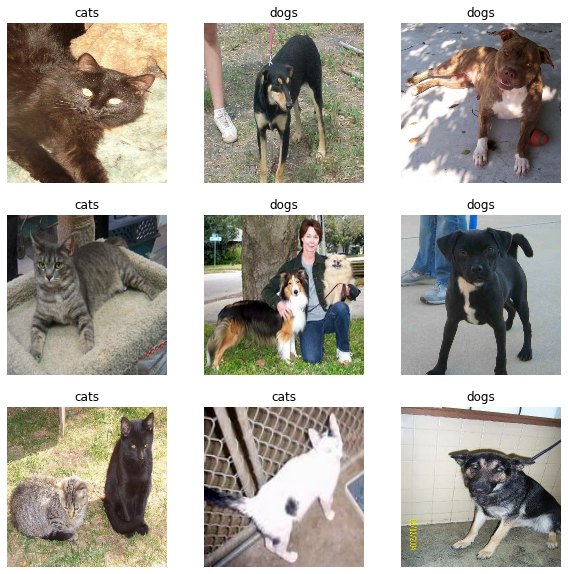

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#Crendo val_data
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
#Data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

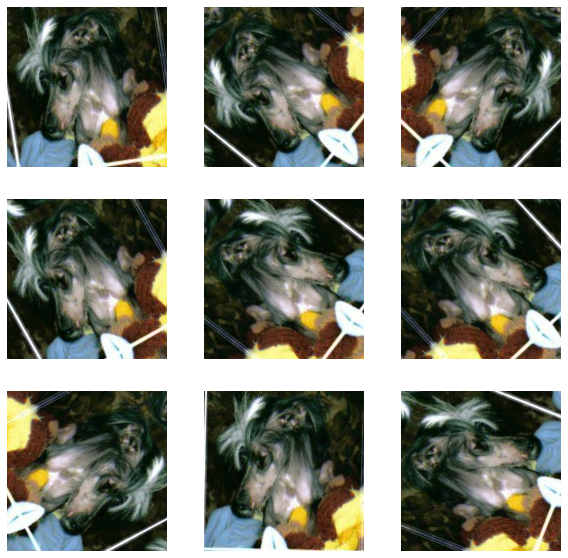

In [ ]:

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
#Reescalamiento 
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.densenet.DenseNet201(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    pooling=None,
    classes=1000,
)

74850304/74836368 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1920)


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 166, 166, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 80, 80, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 80, 80, 64)   256         ['conv1/conv[0][0]']   

In [ ]:
#Agregando capas de clasificación 
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1920)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
#Compilación del modelo
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 densenet201 (Functional)    (None, 5, 5, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0     

In [ ]:
#Evaluación con el modelo solo pre-entrenado

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 12s 153ms/step - loss: 0.6655 - accuracy: 0.5668


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.67
initial accuracy: 0.57


In [ ]:
#Entrenando el modelo

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 341s 5s/step - loss: 0.7444 - accuracy: 0.5730 - val_loss: 0.5386 - val_accuracy: 0.7351
Epoch 2/10
63/63 [==============================] - 329s 5s/step - loss: 0.5378 - accuracy: 0.7170 - val_loss: 0.3436 - val_accuracy: 0.8812
Epoch 3/10
63/63 [==============================] - 300s 5s/step - loss: 0.4078 - accuracy: 0.7980 - val_loss: 0.2490 - val_accuracy: 0.9381
Epoch 4/10
63/63 [==============================] - 323s 5s/step - loss: 0.3360 - accuracy: 0.8535 - val_loss: 0.1926 - val_accuracy: 0.9567
Epoch 5/10
63/63 [==============================] - 323s 5s/step - loss: 0.2807 - accuracy: 0.8845 - val_loss: 0.1574 - val_accuracy: 0.9641
Epoch 6/10
63/63 [==============================] - 320s 5s/step - loss: 0.2518 - accuracy: 0.8945 - val_loss: 0.1308 - val_accuracy: 0.9715
Epoch 7/10
63/63 [==============================] - 323s 5s/step - loss: 0.2250 - accuracy: 0.9095 - val_loss: 0.1158 - val_accuracy: 0.9765
Epoch 8/10
63

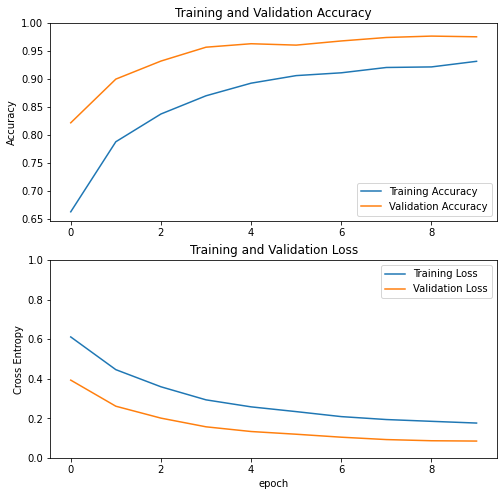

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Fine tuning
Notee que solo se han entrenado las capas finales, las de clasificación, y no las de extracción de caracteristicas.
Por lo que es buena idea "descongelar algunas conexiones para reentrenarlas.

In [ ]:
#Descongelando
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  #congelando de nuevo
  layer.trainable = False

Number of layers in the base model:  707


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 densenet201 (Functional)    (None, 5, 5, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0     

In [ ]:
#Parametros para entrenar
len(model.trainable_variables)

521

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 58s 396ms/step - loss: 0.1476 - accuracy: 0.9455 - val_loss: 0.0378 - val_accuracy: 0.9901
Epoch 11/20
63/63 [==============================] - 19s 303ms/step - loss: 0.0802 - accuracy: 0.9655 - val_loss: 0.0243 - val_accuracy: 0.9901
Epoch 12/20
63/63 [==============================] - 19s 306ms/step - loss: 0.0727 - accuracy: 0.9725 - val_loss: 0.0287 - val_accuracy: 0.9913
Epoch 13/20
63/63 [==============================] - 19s 306ms/step - loss: 0.0499 - accuracy: 0.9800 - val_loss: 0.0896 - val_accuracy: 0.9740
Epoch 14/20
63/63 [==============================] - 19s 306ms/step - loss: 0.0513 - accuracy: 0.9790 - val_loss: 0.0264 - val_accuracy: 0.9876
Epoch 15/20
63/63 [==============================] - 20s 308ms/step - loss: 0.0453 - accuracy: 0.9850 - val_loss: 0.0240 - val_accuracy: 0.9901
Epoch 16/20
63/63 [==============================] - 20s 308ms/step - loss: 0.0341 - accuracy: 0.9900 - val_loss: 0.0237 - val_accuracy:

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

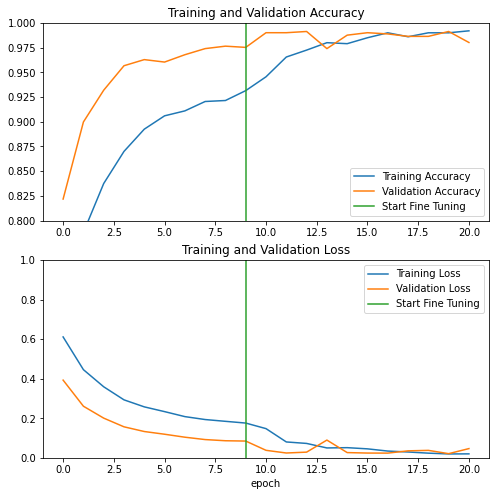

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 98ms/step - loss: 0.0238 - accuracy: 0.9896
Test accuracy : 0.9895833134651184


Predictions:
 [0 1 1 1 0 0 0 1 1 0 0 0 0 1 1 1 0 0 1 0 1 1 1 0 1 0 1 0 0 0 0 1]
Labels:
 [0 1 1 1 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 1 1 0 1 0 1 0 0 0 0 1]


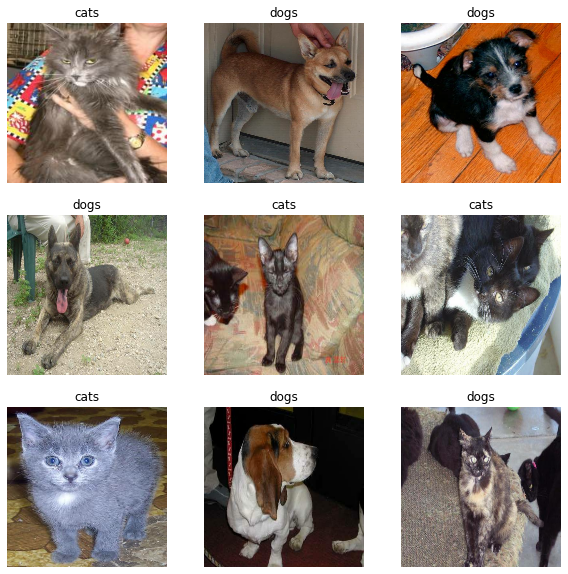

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")